In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers  import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "auto")
print(f"Using  device: {device}")

/home/cqilab/anaconda3/envs/anas_env/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-07-23 16:43:11.158809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 16:43:11.323594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753256591.395451  346782 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already

Using  device: cuda


In [3]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
train_dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=8)

Input shape:  torch.Size([8, 1, 28, 28])
Labels:  tensor([0, 3, 2, 5, 8, 2, 1, 9])


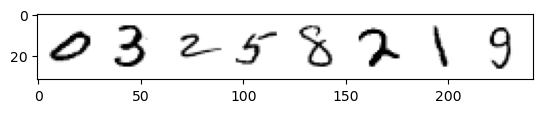

In [5]:
x, y = next(iter(train_dataloader))
print("Input shape: ", x.shape)
print("Labels: ", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")


In [6]:
def corrupt(x, amount):
    """Make corrupt image data with adding noise"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

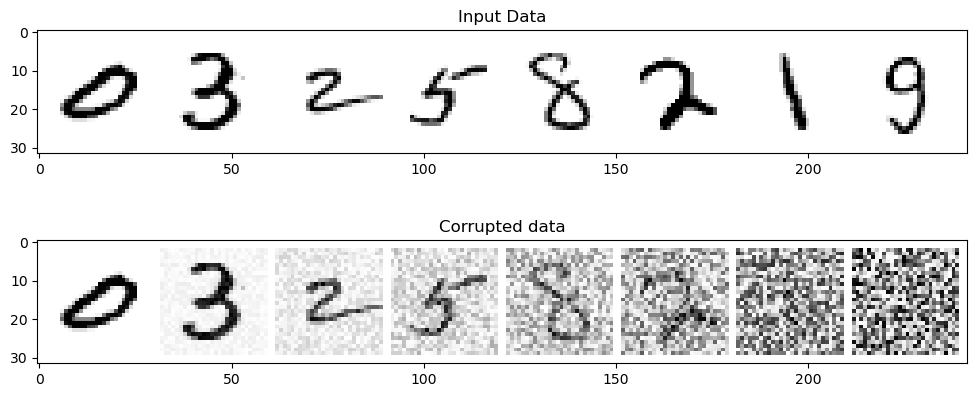

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12,  5))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

## adding noise
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ])
        
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        h = []
        
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # create conv2d layer to input and then add acivation function
            if i < 2: # except for the last layer
                h.append(x) # add the layer  to the stack
                x = self.downscale(x) # add maxpool2d after the conv2d
                
        for i, l in enumerate(self.up_layers):
            if i > 0: # except for the first layer
                x = self.upscale(x) # create upsample for scale factor 2
                x += h.pop() # add the gradient from the downlayer by popping from the last index added 
            x = self.act(l(x)) # start with conv2d layer and add acivation function 
            
        return x
        
        
        

In [9]:
net = UNet()
x  = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [10]:
sum([p.numel() for p in net.parameters()])

309057

Finished with avg loss: 0.027454735401437988 in epoch: 0
Finished with avg loss: 0.021171194562779817 in epoch: 1
Finished with avg loss: 0.019111529078040677 in epoch: 2


(0.0, 0.1)

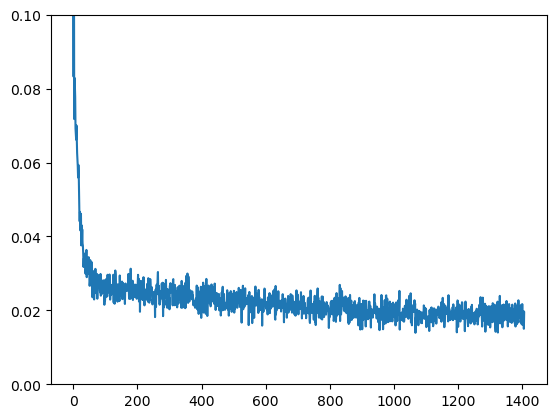

In [13]:
batch_size = 128

train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

losses = []

loss_fn = nn.MSELoss()

net = UNet()
net.to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

n_epochs = 3

for epoch in range(n_epochs):
    
    for x, y in train_dataloader:
        
        x = x.to(device)
        
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        
        result = net(noisy_x)
        
        loss = loss_fn(result, x)
        
        
        
        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished with avg loss: {avg_loss} in epoch: {epoch}")
        
        
plt.plot(losses)
plt.ylim(0, 0.1)

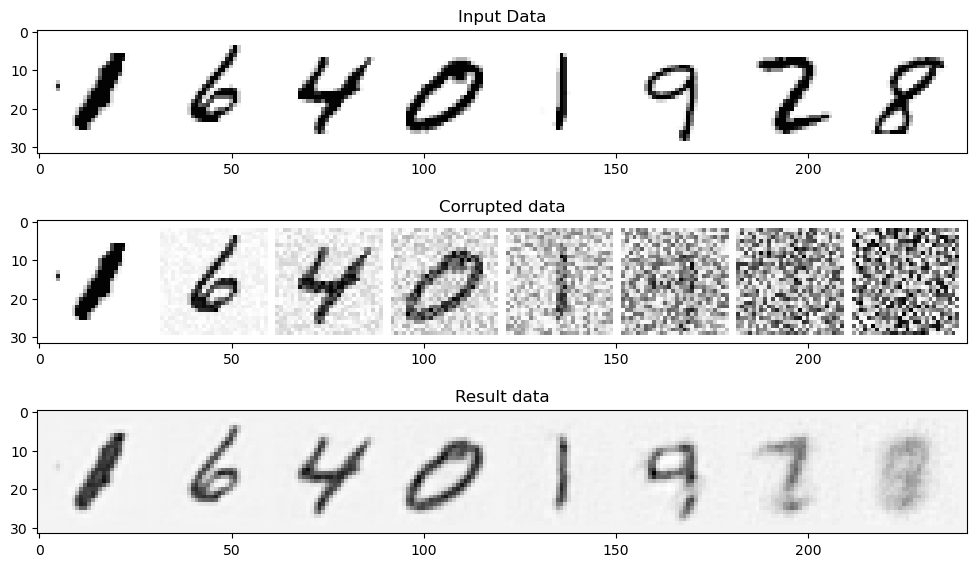

In [14]:
x, y = next(iter(train_dataloader))

x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    result = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12,  7))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1), cmap="Greys")

axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

axs[2].set_title("Result data")
axs[2].imshow(torchvision.utils.make_grid(result)[0], cmap="Greys")

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
        
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())
    
fig, axs = plt.subplots(n_steps, 2, figsize=(9,4), sharex=True)
axs[0,0].set_title("x (model input)")
axs[0,1].set_title("model_prediction")

for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1), cmap="Greys")
    axs[i,0].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1), cmap="Greys")